In [43]:
import os 
import pandas as pd
import numpy as np
import pickle
import time


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import matplotlib.colors as pltcl
from palettable.scientific.sequential import LaJolla_5,Devon_3
from palettable.scientific.diverging import Roma_12

import matplotlib
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42

In [ ]:
# metainfopath: The path will contain metainformation of the experiment.
# resultfolderpath: The path will numpy array files which store zscored perievent activity and a summarized dataframe containing data for each cell.

rootpath = r"...\Data\Figure 3, 4, 5, S6, S7, S8"
metainfopath = os.path.join(rootpath, "meta")
resultfolderpath = os.path.join(rootpath, "data")
figurepath = os.path.join(rootpath, "figure")
statspath = os.path.join(rootpath, "stats")
clusteringpath = os.path.join(rootpath, "clustering")
for x in [figurepath,statspath,clusteringpath]:
    if not os.path.exists(x):
        os.mkdir(x)

In [18]:
# load results from the peri-event analysis
# This result dataframe contains metainformation of the cell.
analysis_metainfo = pd.read_csv(os.path.join(resultfolderpath,"male_analysis_magnitude.csv"),index_col = False)
# load parameters saved in a dictionary file
with open(os.path.join(metainfopath,"parameter_dict.pickle"),'rb') as handle:
    parameter_dict = pickle.load(handle)

In [19]:
# set parameters that will be used afterwards
video_framerate = 30
imaging_framerate = 10
step_size = video_framerate//imaging_framerate
std_threshold = 2

point_event_duration_seconds = 120 # duration of the post-event analysis window in seconds


In [ ]:
# Load the raw data
zscores = np.load(os.path.join(resultfolderpath,'Ejaculation_longer_all_norm_zscore_snip_array.npy'))


In [ ]:
# Subset the cells based on the acute positive response to mating Ejaculation.
responding_zscores = zscores[:,(analysis_metainfo.Ejaculation_positive_responding_cells)]
responding_analysis_metainfo = analysis_metainfo.loc[(analysis_metainfo.Ejaculation_positive_responding_cells),:].reset_index()

# Set clustering parameters

In [27]:
before_frames = parameter_dict['before_frames']
after_frames = parameter_dict['after_frames']
before_window = parameter_dict['before_window']
after_window = parameter_dict['after_window']
signal_framerate = parameter_dict['signal_framerate']

after_window_for_quantification = parameter_dict['after_window_for_quantification']

In [28]:
# Set parameters necessary for the clustering
before_frames = int(before_window * signal_framerate)
after_frames = int(point_event_duration_seconds * signal_framerate)
sort_window = [before_frames,int(before_frames + after_frames)]
cmax = 5
cmin = -5

In [29]:
# Set a period to 
pre_second = before_window
post_second = point_event_duration_seconds

pre_window = int(signal_framerate * pre_second)
post_window = int(signal_framerate * post_second)

# Start clustering

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF


In [54]:
from time import localtime, strftime

In [ ]:
colors_for_key = ['green']
trial_types = ['Ejaculation']
cluster_key = strftime("%Y%m%d%H%M", localtime())
strategy_key = 'Ejaculation_long'


## Cluster the cells that were responing to mating Ejaculation positively

In [57]:
# Transpose the perievent activity matrix to fit the clustering algorithm
data_array = responding_zscores.T

In [58]:
# Conduct PCA for dimensionality reduction and save the results
pca = PCA(n_components=min(data_array.shape[0],data_array.shape[1]), whiten=True)
pca.fit(data_array) 
with open(os.path.join(clusteringpath, f'{cluster_key}_pcaresults.pickle'), 'wb') as f:
    pickle.dump(pca, f)

In [59]:
# Load the transformed result and 
transformed_data = pca.transform(data_array)
np.save(os.path.join(clusteringpath,f"{cluster_key}_transformed_data.npy"),transformed_data)

pca_vectors = pca.components_
print('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
#num_retained_pcs = 13
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print('Number of PCs to keep = %d'%(num_retained_pcs))


Number of PCs = 219
Number of PCs to keep = 4


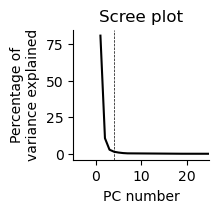

In [60]:
x = 100*pca.explained_variance_ratio_
fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
# ax.set_xlim([0,50])
#[i.set_linewidth(0.5) for i in ax.spines.itervalues()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-5,25)
fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

In [61]:
# set the total number of clusters
max_n_clusters = 11
possible_n_nearest_neighbors = np.linspace(10,70,13,dtype = 'int')

In [62]:
# Spectral clustering
possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


#possible_n_nearest_neighbors = np.array([30,40,30,50,60]) # This should be selected for each dataset
# appropriately. When 4813 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
    
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                model.labels_,
                                                                metric='cosine')
        print('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                    nn,
                                                                                    silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))
        
print('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
silhouette_scores = temp

c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 2, num nearest neighbors = 10: score = 0.377
Done with numclusters = 2, num nearest neighbors = 15: score = 0.368


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 2, num nearest neighbors = 20: score = 0.368
Done with numclusters = 2, num nearest neighbors = 25: score = 0.373


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 2, num nearest neighbors = 30: score = 0.375
Done with numclusters = 2, num nearest neighbors = 35: score = 0.376


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 2, num nearest neighbors = 40: score = 0.388
Done with numclusters = 2, num nearest neighbors = 45: score = 0.384


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 2, num nearest neighbors = 50: score = 0.386
Done with numclusters = 2, num nearest neighbors = 55: score = 0.384
Done with numclusters = 2, num nearest neighbors = 60: score = 0.390


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 2, num nearest neighbors = 65: score = 0.390
Done with numclusters = 2, num nearest neighbors = 70: score = 0.392


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 10: score = 0.365
Done with numclusters = 3, num nearest neighbors = 15: score = 0.351


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 20: score = 0.343
Done with numclusters = 3, num nearest neighbors = 25: score = 0.349


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 30: score = 0.349
Done with numclusters = 3, num nearest neighbors = 35: score = 0.351


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 40: score = 0.338
Done with numclusters = 3, num nearest neighbors = 45: score = 0.345


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 50: score = 0.353
Done with numclusters = 3, num nearest neighbors = 55: score = 0.341


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 60: score = 0.350
Done with numclusters = 3, num nearest neighbors = 65: score = 0.346


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 3, num nearest neighbors = 70: score = 0.351
Done with numclusters = 4, num nearest neighbors = 10: score = 0.417


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 4, num nearest neighbors = 15: score = 0.407
Done with numclusters = 4, num nearest neighbors = 20: score = 0.403


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 4, num nearest neighbors = 25: score = 0.407
Done with numclusters = 4, num nearest neighbors = 30: score = 0.410


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 4, num nearest neighbors = 35: score = 0.412
Done with numclusters = 4, num nearest neighbors = 40: score = 0.410


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 4, num nearest neighbors = 45: score = 0.415
Done with numclusters = 4, num nearest neighbors = 50: score = 0.413


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 4, num nearest neighbors = 55: score = 0.407
Done with numclusters = 4, num nearest neighbors = 60: score = 0.403


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 4, num nearest neighbors = 65: score = 0.394
Done with numclusters = 4, num nearest neighbors = 70: score = 0.385


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 10: score = 0.450
Done with numclusters = 5, num nearest neighbors = 15: score = 0.469


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 20: score = 0.469
Done with numclusters = 5, num nearest neighbors = 25: score = 0.472


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 30: score = 0.474
Done with numclusters = 5, num nearest neighbors = 35: score = 0.470


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 40: score = 0.466
Done with numclusters = 5, num nearest neighbors = 45: score = 0.465


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 50: score = 0.463
Done with numclusters = 5, num nearest neighbors = 55: score = 0.461


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 60: score = 0.457
Done with numclusters = 5, num nearest neighbors = 65: score = 0.451


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 5, num nearest neighbors = 70: score = 0.448
Done with numclusters = 6, num nearest neighbors = 10: score = 0.362


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 6, num nearest neighbors = 15: score = 0.376
Done with numclusters = 6, num nearest neighbors = 20: score = 0.416


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 6, num nearest neighbors = 25: score = 0.434
Done with numclusters = 6, num nearest neighbors = 30: score = 0.436


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 6, num nearest neighbors = 35: score = 0.436
Done with numclusters = 6, num nearest neighbors = 40: score = 0.446


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 6, num nearest neighbors = 45: score = 0.434
Done with numclusters = 6, num nearest neighbors = 50: score = 0.448


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 6, num nearest neighbors = 55: score = 0.455
Done with numclusters = 6, num nearest neighbors = 60: score = 0.446


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 6, num nearest neighbors = 65: score = 0.432
Done with numclusters = 6, num nearest neighbors = 70: score = 0.422


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 10: score = 0.344
Done with numclusters = 7, num nearest neighbors = 15: score = 0.362


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 20: score = 0.403
Done with numclusters = 7, num nearest neighbors = 25: score = 0.416


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 30: score = 0.404
Done with numclusters = 7, num nearest neighbors = 35: score = 0.409


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 40: score = 0.400
Done with numclusters = 7, num nearest neighbors = 45: score = 0.412


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 50: score = 0.408
Done with numclusters = 7, num nearest neighbors = 55: score = 0.404


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 60: score = 0.410
Done with numclusters = 7, num nearest neighbors = 65: score = 0.396


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 7, num nearest neighbors = 70: score = 0.384
Done with numclusters = 8, num nearest neighbors = 10: score = 0.311


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 8, num nearest neighbors = 15: score = 0.339
Done with numclusters = 8, num nearest neighbors = 20: score = 0.340
Done with numclusters = 8, num nearest neighbors = 25: score = 0.371


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 8, num nearest neighbors = 30: score = 0.367
Done with numclusters = 8, num nearest neighbors = 35: score = 0.367


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 8, num nearest neighbors = 40: score = 0.372
Done with numclusters = 8, num nearest neighbors = 45: score = 0.371


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 8, num nearest neighbors = 50: score = 0.344
Done with numclusters = 8, num nearest neighbors = 55: score = 0.336
Done with numclusters = 8, num nearest neighbors = 60: score = 0.361


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 8, num nearest neighbors = 65: score = 0.331
Done with numclusters = 8, num nearest neighbors = 70: score = 0.266


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 10: score = 0.178
Done with numclusters = 9, num nearest neighbors = 15: score = 0.241


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 20: score = 0.302
Done with numclusters = 9, num nearest neighbors = 25: score = 0.337


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 30: score = 0.341
Done with numclusters = 9, num nearest neighbors = 35: score = 0.355


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 40: score = 0.337
Done with numclusters = 9, num nearest neighbors = 45: score = 0.344


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 50: score = 0.307
Done with numclusters = 9, num nearest neighbors = 55: score = 0.281


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 60: score = 0.278
Done with numclusters = 9, num nearest neighbors = 65: score = 0.281


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 9, num nearest neighbors = 70: score = 0.273
Done with numclusters = 10, num nearest neighbors = 10: score = 0.204


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 10, num nearest neighbors = 15: score = 0.230
Done with numclusters = 10, num nearest neighbors = 20: score = 0.273


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 10, num nearest neighbors = 25: score = 0.283
Done with numclusters = 10, num nearest neighbors = 30: score = 0.282


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 10, num nearest neighbors = 35: score = 0.289
Done with numclusters = 10, num nearest neighbors = 40: score = 0.321


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 10, num nearest neighbors = 45: score = 0.291
Done with numclusters = 10, num nearest neighbors = 50: score = 0.294
Done with numclusters = 10, num nearest neighbors = 55: score = 0.264


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 10, num nearest neighbors = 60: score = 0.274
Done with numclusters = 10, num nearest neighbors = 65: score = 0.286


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 10, num nearest neighbors = 70: score = 0.241
Done with numclusters = 11, num nearest neighbors = 10: score = 0.209


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 11, num nearest neighbors = 15: score = 0.252
Done with numclusters = 11, num nearest neighbors = 20: score = 0.285
Done with numclusters = 11, num nearest neighbors = 25: score = 0.309


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 11, num nearest neighbors = 30: score = 0.290
Done with numclusters = 11, num nearest neighbors = 35: score = 0.331
Done with numclusters = 11, num nearest neighbors = 40: score = 0.328


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 11, num nearest neighbors = 45: score = 0.281
Done with numclusters = 11, num nearest neighbors = 50: score = 0.260


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 11, num nearest neighbors = 55: score = 0.230
Done with numclusters = 11, num nearest neighbors = 60: score = 0.240


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Done with numclusters = 11, num nearest neighbors = 65: score = 0.246
Done with numclusters = 11, num nearest neighbors = 70: score = 0.226
Done with model fitting


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [63]:
# save the results
with open(os.path.join(clusteringpath,f'{cluster_key}_silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(silhouette_scores, f)
    


In [65]:
# display the parameters which had the best silhouette score
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

#print(n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                    affinity='nearest_neighbors',
                    n_neighbors=n_nearest_neighbors)
model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))


Number of clusters = 5, average silhouette = 0.474


c:\Users\stuberadmin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [67]:
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels,concatenated_result,
                     pre_window_size,):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(concatenated_result[rawlabels==label, int(pre_window_size):2*int(pre_window_size)])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels   

In [85]:
# get the new labels and rename them so the largest ones are the younger
newlabels = reorder_clusters(model.labels_,data_array,before_frames)
# rename the labels based on post-hoc discriptions
# I want to rename the original label3 as 4 and the label4 as 3.
newlabels = np.array([4 if f == 3 else 3 if f == 4 else f for f in newlabels],dtype = int)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

np.save(os.path.join(clusteringpath, f'{cluster_key}_spectral_clusterlabels.npy'), newlabels)
